# Keras Prediction
4 2D CNN Convolutional Layer
---

Credits:
- https://www.kaggle.com/ejlok1/audio-emotion-part-6-2d-cnn-66-accuracy

In [47]:
# Credit to:
# https://www.kaggle.com/ejlok1/audio-emotion-part-6-2d-cnn-66-accuracy

# Keras
from keras.utils import np_utils, to_categorical

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import numpy as np
import pandas as pd
import os

# Local
from source_pytorch.kerasLoader import KerasLoader
from source_pytorch.kerasCnnModel import KerasCnnModel
from source_pytorch.kerasResultTools import Get_results

In [76]:
#Set the parameters and load the data
setting = {
  "audio_duration"  :   4,
  "n_mfcc"          :   40,
  "sampling_rate"   :   44100,
  "audio_duration"  :   4,
  "dataroot"        :   "AudioDataset",
  "batch_size"      :   16,
  "epochs"          :   50
}

In [77]:
#Get the reference
ref = pd.read_csv("./ReferenceData.csv")#[:200]
#Print head / test successfull load
ref.head()

,label,fname
0,fearful,03-01-06-01-02-02-02.wav
1,angry,03-01-05-01-02-01-16.wav
2,surprise,03-01-08-01-01-01-14.wav
3,fearful,03-01-06-01-02-02-16.wav
4,angry,03-01-05-01-02-01-02.wav


In [78]:
#Split the Train and Test dataset
X_train, X_test, y_train, y_test = train_test_split(ref["fname"]
                                                    ,ref["label"]
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=50
                                                   )
#Split the Train and Validation dataset
X_train, X_valid , y_train, y_valid = train_test_split(X_train
                                                    , y_train
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=50
                                                   )


#Merge data and prediction in 1 dataset for train validation and test
train_df = pd.concat([X_train,y_train], axis = 1)  
valid_df =  pd.concat([X_valid,y_valid], axis = 1)
test_df = pd.concat([X_test,y_test], axis = 1)

print('Dataset Len:\t Train - {} \tValid Dataset - {} \tTest Dataset - {}'.format(len(train_df), len(valid_df), len(test_df)))

Dataset Len:	 Train - 810 	Valid Dataset - 270 	Test Dataset - 360


In [79]:
train_mfcc = KerasLoader().prepare_data(train_df,setting["n_mfcc"],setting["sampling_rate"], setting["audio_duration"], dataroot = setting["dataroot"] )
valid_mfcc = KerasLoader().prepare_data(valid_df,setting["n_mfcc"],setting["sampling_rate"], setting["audio_duration"], dataroot = setting["dataroot"] )
test_mfcc = KerasLoader().prepare_data(test_df,setting["n_mfcc"],setting["sampling_rate"], setting["audio_duration"], dataroot = setting["dataroot"] )

100%|██████████| 360/360 [00:28<00:00, 12.67it/s]


In [80]:
# One hot encode the target 
lb = LabelEncoder()
y_train_converted = np_utils.to_categorical(lb.fit_transform(y_train))
y_valid_converted = np_utils.to_categorical(lb.fit_transform(y_valid))
y_test_converted = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(train_mfcc, axis=0)
std = np.std(train_mfcc, axis=0)

X_train_norm = (train_mfcc - mean)/std
X_valid_norm = (valid_mfcc - mean)/std
X_test_norm = (test_mfcc - mean)/std

In [81]:
%%time

# Build CNN model 
model = KerasCnnModel().load(n=setting["n_mfcc"])

#Fit and Valid the data
model_history = model.fit(X_train_norm, y_train_converted, validation_data=(X_valid_norm, y_valid_converted), 
                    batch_size=setting["batch_size"], verbose = 2, epochs=setting["epochs"])

Train on 810 samples, validate on 270 samples
Epoch 1/50
 - 105s - loss: 2.1067 - acc: 0.2481 - val_loss: 1.9054 - val_acc: 0.2704
Epoch 2/50
 - 100s - loss: 1.9358 - acc: 0.2531 - val_loss: 1.8272 - val_acc: 0.2778
Epoch 3/50
 - 100s - loss: 1.9242 - acc: 0.2704 - val_loss: 1.7697 - val_acc: 0.3074
Epoch 4/50
 - 96s - loss: 1.8859 - acc: 0.2506 - val_loss: 1.7566 - val_acc: 0.3407
Epoch 5/50
 - 96s - loss: 1.8443 - acc: 0.2963 - val_loss: 1.7478 - val_acc: 0.3593
Epoch 6/50
 - 86s - loss: 1.8113 - acc: 0.3148 - val_loss: 1.9108 - val_acc: 0.2667
Epoch 7/50
 - 75s - loss: 1.7317 - acc: 0.3444 - val_loss: 1.7672 - val_acc: 0.3185
Epoch 8/50
 - 75s - loss: 1.6949 - acc: 0.3321 - val_loss: 1.7266 - val_acc: 0.3407
Epoch 9/50
 - 74s - loss: 1.6947 - acc: 0.3519 - val_loss: 1.7739 - val_acc: 0.3296
Epoch 10/50
 - 74s - loss: 1.6100 - acc: 0.3840 - val_loss: 1.7629 - val_acc: 0.3630
Epoch 11/50
 - 73s - loss: 1.6046 - acc: 0.3951 - val_loss: 1.7360 - val_acc: 0.3593
Epoch 12/50
 - 73s - loss

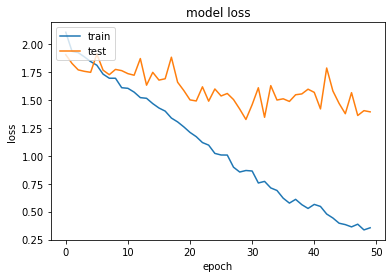

acc: 47.50%


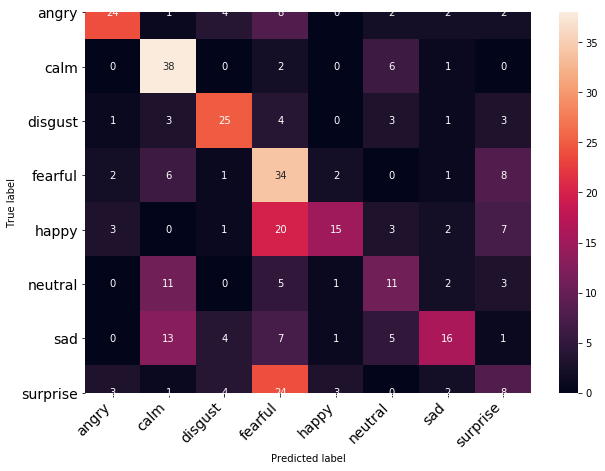

In [82]:
#Show the result
results = Get_results(model_history,model,X_test_norm ,y_test_converted, ref.label.unique())
results.create_plot(model_history)
results.create_results(model,X_test_norm, y_test_converted)
results.confusion_results(X_test_norm, y_test_converted, ref.label.unique(), model,lb)